# Expand the dataset by classifying using Mobilenetv2

## 2024-07-01

In [12]:
import cv2
import os
import numpy as np
import pandas as pd

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.rc("font", size=14)
plt.rc("axes", labelsize=14, titlesize=14)
plt.rc("legend", fontsize=14)
plt.rc("xtick", labelsize=10)
plt.rc("ytick", labelsize=10)

In [14]:
import tensorflow as tf
import keras

print(tf.__version__)
tf.random.set_seed(42)
keras.backend.clear_session()

2.16.2


In [15]:
from sklearn.metrics import (
    confusion_matrix,
    balanced_accuracy_score,
    precision_score,
    f1_score,
)

In [16]:
from sklearn.metrics import ConfusionMatrixDisplay


def get_confusion_matrix(y_test, y_pred, class_names):

    fig, ax = plt.subplots(figsize=(8, 8))
    cm = ConfusionMatrixDisplay.from_predictions(
        y_test,
        y_pred,
        ax=ax,
        xticks_rotation="vertical",
        colorbar=False,
        normalize="true",
        display_labels=class_names,
    )

    plt.rc("font", size=12)
    ax.set_title(f"Confusion Matrix")

In [17]:
def plot_history(history, metrics):
    history_df = pd.DataFrame.from_dict(history.history)
    sns.lineplot(data=history_df[metrics])
    plt.xlabel("epochs")
    plt.ylabel("metric")

In [18]:
path_in = "/home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262_cleaned"

In [19]:
# from sklearn.preprocessing import LabelEncoder

# X = []
# y = []

# fnames = [fnames for fnames in os.walk(path_in)][1:]

# for class_dir, _, file_name_list in fnames:
#     lbl = class_dir.split("/")[7] # hordercoded labels here, they depend on the path
#     for f in file_name_list:
#         img = cv2.imread(os.path.join(class_dir, f), cv2.IMREAD_GRAYSCALE)
#         X.append(img)
#         y.append(lbl)

# X = rescale(X) # Run rescale layers before

# le = LabelEncoder()
# y = le.fit_transform(y)

# X.shape, y.shape

In [20]:
from keras import layers

AUTOTUNE = tf.data.AUTOTUNE

BATCH_SIZE = 32
IMG_SIZE = (64, 64)

train_ds, test_ds = keras.utils.image_dataset_from_directory(
    path_in,
    labels="inferred",
    label_mode="int",
    class_names=["discocyte", "holly_leaf", "granular", "sickle", "echinocyte"],
    color_mode="grayscale",
    batch_size=BATCH_SIZE,
    image_size=IMG_SIZE,
    shuffle=True,
    seed=93,
    validation_split=0.2,
    subset="both",
    data_format="channels_last",
    verbose=True,
)


rescale = tf.keras.Sequential([layers.Rescaling(1.0 / 255)])
data_augmentation = tf.keras.Sequential(
    [
        layers.RandomFlip("horizontal_and_vertical"),
        layers.RandomRotation(0.2),
        layers.RandomTranslation(0.2, 0.2),
        layers.RandomContrast(0.2),
        layers.RandomBrightness(0.2),
    ]
)


def prepare(ds, rescle=False, augment=False):

    if rescale:
        ds = ds.map(lambda x, y: (rescale(x), y), num_parallel_calls=AUTOTUNE)

    # Use data augmentation only on the training set.
    if augment:
        ds = ds.map(
            lambda x, y: (data_augmentation(x, training=True), y),
            num_parallel_calls=AUTOTUNE,
        )

    # Use buffered prefetching on all datasets.
    return ds.prefetch(buffer_size=AUTOTUNE)


class_names = test_ds.class_names

# train_ds = prepare(train_ds, augment=True)
# test_ds = prepare(test_ds)

train_ds = prepare(train_ds, rescle=True, augment=True)
test_ds = prepare(test_ds, rescle=True, augment=False)


# Verify shapes
for data, label in train_ds.take(1):
    print(f"Train data shape: {data.shape}, label shape: {label.shape}")

NotFoundError: Could not find directory /home/t.afanasyeva/deep_learning_anaemias/resources/cytpix/23-714262_cleaned

In [ ]:
EPOCHS = 200

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping, LearningRateScheduler

earlystopper = EarlyStopping(monitor="val_loss", patience=8, restore_best_weights=True)


def learning_rate_schedule(epoch, lr):
    if epoch < 10:
        return lr
    else:
        return (lr * tf.math.exp(-0.1)).numpy()


lr_scheduler = LearningRateScheduler(learning_rate_schedule)

In [ ]:
model = keras.applications.MobileNetV2(
    input_shape=(64, 64, 1),
    alpha=1.0,
    include_top=True,
    weights=None,
    input_tensor=None,
    pooling="avg",
    classes=5,
    classifier_activation="softmax",
)

model.compile(
    optimizer="nadam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [ ]:
model.summary()

In [ ]:
with tf.device("GPU:0"):
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        callbacks=[earlystopper, lr_scheduler],
        epochs=EPOCHS,
    )

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 46s 156ms/step - accuracy: 0.2484 - loss: 1.7904 - val_accuracy: 0.2660 - val_loss: 1.5934 - learning_rate: 0.0010
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 20ms/step - accuracy: 0.2402 - loss: 1.5786 - val_accuracy: 0.2646 - val_loss: 1.5783 - learning_rate: 0.0010
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2396 - loss: 1.5558 - val_accuracy: 0.2646 - val_loss: 1.5667 - learning_rate: 0.0010
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2675 - loss: 1.5478 - val_accuracy: 0.2660 - val_loss: 1.5492 - learning_rate: 0.0010
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2588 - loss: 1.5542 - val_accuracy: 0.2646 - val_loss: 1.5450 - learning_rate: 0.0010
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2463 - loss: 1.5482 - val_accuracy: 0.2660 - val_loss: 1.5516 - learning_rate: 0.0010
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2273 - loss: 1.5625 

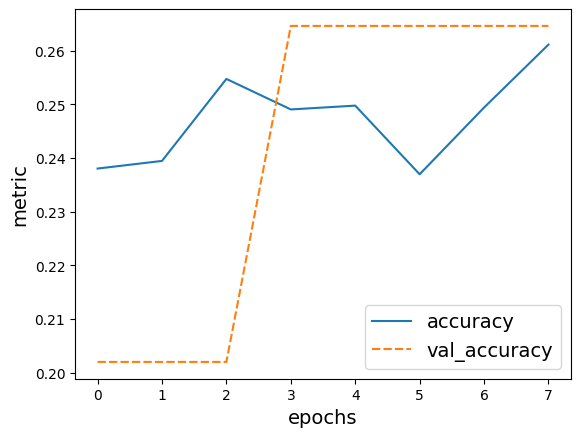

In [ ]:
plot_history(history, ["accuracy", "val_accuracy"])

In [ ]:
from tensorflow.keras import regularizers

# Define image dimensions and number of channels (1 for grayscale, 3 for RGB)
image_height, image_width, num_channels = 64, 64, 1

# Define the number of classes
num_classes = 5


# Create the CNN model
def create_cnn_model(input_shape, num_classes):
    model = keras.models.Sequential()

    # Convolutional Layer 1
    model.add(
        layers.Conv2D(
            32,
            (3, 3),
            activation="relu",
            kernel_regularizer=regularizers.l2(0.001),
            input_shape=input_shape,
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 2
    model.add(
        layers.Conv2D(
            64, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Convolutional Layer 3
    model.add(
        layers.Conv2D(
            128, (3, 3), activation="relu", kernel_regularizer=regularizers.l2(0.001)
        )
    )
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D((2, 2)))

    # Flatten the output from the convolutional layers
    model.add(layers.Flatten())

    # Fully Connected Layer 1
    model.add(
        layers.Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.001))
    )
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Fully Connected Layer 2 (optional)
    model.add(
        layers.Dense(64, activation="relu", kernel_regularizer=regularizers.l2(0.001))
    )
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))

    # Output Layer
    model.add(layers.Dense(num_classes, activation="softmax"))

    return model

In [ ]:
input_shape = (image_height, image_width, num_channels)
model = create_cnn_model(input_shape, num_classes)

model.compile(
    optimizer="nadam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)
model.summary()

In [ ]:
mobile_net = keras.saving.load_model(
    "/home/t.afanasyeva/deep_learning_anaemias/model_zoo/mobile_net_v00.keras",
    custom_objects=None,
    compile=True,
    safe_mode=True,
)

In [ ]:
mobile_net = tf.keras.Model(
    inputs=mobile_net.inputs, outputs=mobile_net.layers[-2].output
)

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import (
    GlobalAveragePooling2D,
    Dense,
    BatchNormalization,
    ReLU,
)
from tensorflow.keras.regularizers import l2


model = Sequential()

model.add(mobile_net)

mobile_net.trainable = False

model.add(Dense(1024, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Dense(1024, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Dense(512, kernel_regularizer=l2(0.01)))
model.add(BatchNormalization())
model.add(ReLU())

model.add(Dense(5, activation="softmax"))  # Final layer with softmax activation

In [ ]:
model.compile(
    optimizer="nadam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

In [ ]:
with tf.device("GPU:0"):
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        callbacks=[earlystopper, lr_scheduler],
        epochs=EPOCHS,
    )

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 12ms/step - accuracy: 0.2420 - loss: 1.7258 - val_accuracy: 0.1935 - val_loss: 1.9685 - learning_rate: 0.0010
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2399 - loss: 1.8915 - val_accuracy: 0.1679 - val_loss: 1.7192 - learning_rate: 0.0010
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 9ms/step - accuracy: 0.2452 - loss: 1.7031 - val_accuracy: 0.1380 - val_loss: 2.3581 - learning_rate: 0.0010
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2650 - loss: 1.7628 - val_accuracy: 0.2646 - val_loss: 2.9155 - learning_rate: 0.0010
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step - accuracy: 0.2562 - loss: 1.7845 - val_accuracy: 0.2020 - val_loss: 1.7092 - learning_rate: 0.0010
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2410 - loss: 1.6715 - val_accuracy: 0.2020 - val_loss: 1.6546 - learning_rate: 0.0010
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 1s 10ms/step - accuracy: 0.2506 - loss: 1.6684 - v

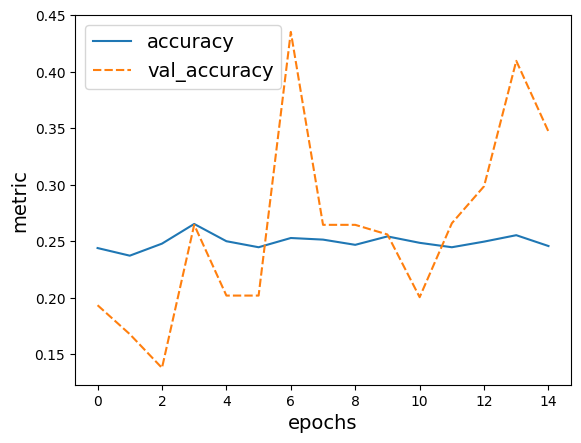

In [ ]:
plot_history(history, ["accuracy", "val_accuracy"])

In [ ]:
y_pred_list = []

y_pred = model.predict(test_ds)
y_pred = y_pred.argmax(axis=1)

y_test = []
for images, lbls in test_ds:
    y_test.extend(lbls.numpy())

22/22 ━━━━━━━━━━━━━━━━━━━━ 4s 97ms/step


2024-07-02 00:30:10.283398: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


In [ ]:
accuracy = balanced_accuracy_score(y_test, y_pred)
f1_score_model = f1_score(y_test, y_pred, average="weighted")
precision = precision_score(y_test, y_pred, average="weighted")
scores = {
    "test_balanced_accuracy": accuracy,
    "test_f1_weighted": f1_score_model,
    "test_precision_weighted": precision,
}
scores = pd.DataFrame(scores, index=[0])
scores

,test_balanced_accuracy,test_f1_weighted,test_precision_weighted
0,0.388535,0.461741,0.431659


In [ ]:
model = keras.applications.MobileNetV3Large(
    input_shape=(64, 64, 1),
    alpha=0.5,
    minimalistic=False,
    include_top=True,
    weights="imagenet",
    input_tensor=None,
    classes=5,
    pooling=None,
    dropout_rate=0.8,
    classifier_activation="softmax",
    include_preprocessing=True,
)

model.compile(
    optimizer="nadam",
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=["accuracy"],
)

NameError: name 'keras' is not defined

In [ ]:
model.summary()

In [ ]:
with tf.device("GPU:0"):
    history = model.fit(
        train_ds,
        validation_data=test_ds,
        callbacks=[earlystopper, lr_scheduler],
        epochs=EPOCHS,
    )

Epoch 1/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 63s 293ms/step - accuracy: 0.2356 - loss: 1.7507 - val_accuracy: 0.2660 - val_loss: 1.5838 - learning_rate: 0.0010
Epoch 2/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 19ms/step - accuracy: 0.2535 - loss: 1.6596 - val_accuracy: 0.2660 - val_loss: 1.5850 - learning_rate: 0.0010
Epoch 3/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 18ms/step - accuracy: 0.2318 - loss: 1.6081 - val_accuracy: 0.2646 - val_loss: 1.5829 - learning_rate: 0.0010
Epoch 4/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2469 - loss: 1.5610 - val_accuracy: 0.2646 - val_loss: 1.5707 - learning_rate: 0.0010
Epoch 5/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 16ms/step - accuracy: 0.2394 - loss: 1.5583 - val_accuracy: 0.2646 - val_loss: 1.5565 - learning_rate: 0.0010
Epoch 6/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2420 - loss: 1.5500 - val_accuracy: 0.2646 - val_loss: 1.5456 - learning_rate: 0.0010
Epoch 7/200
88/88 ━━━━━━━━━━━━━━━━━━━━ 2s 17ms/step - accuracy: 0.2613 - loss: 1.5334 

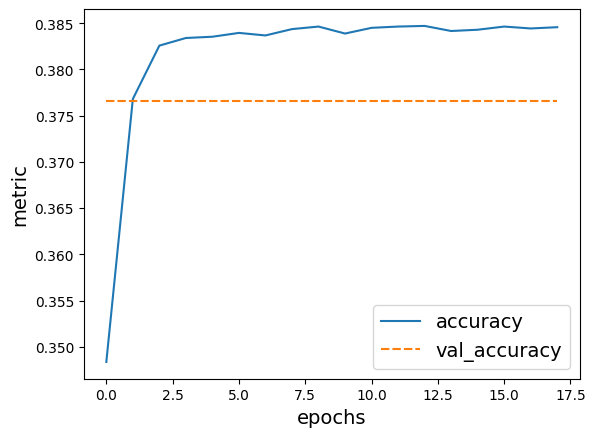

In [ ]:
plot_history(history, ["accuracy", "val_accuracy"])

In [ ]:
# from sklearn.model_selection import KFold

# train_images = np.concatenate(list(train_ds.map(lambda x, y:x)))
# train_labels = np.concatenate(list(train_ds.map(lambda x, y:y)))

# val_images = np.concatenate(list(test_ds.map(lambda x, y:x)))
# val_labels = np.concatenate(list(test_ds.map(lambda x, y:y)))

# inputs = np.concatenate((train_images, val_images), axis=0)
# targets = np.concatenate((train_labels, val_labels), axis=0)

# kfold = KFold(n_splits=5, shuffle=True)
# scores_list = []
# for train, test in kfold.split(inputs, targets):

#       model = keras.applications.MobileNetV3Large(
#       input_shape=(64, 64, 1),
#       alpha=1.0,
#       minimalistic=False,
#       include_top=True,
#       weights=None,
#       input_tensor=None,
#       classes=5,
#       pooling=None,
#       dropout_rate=0.9,
#       classifier_activation="softmax",
#       include_preprocessing=True,
#       )

#       model.compile(
#       optimizer="nadam",
#       loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
#       metrics=["accuracy"],
#       )

#       with tf.device('/cpu:0'):
#             history = model.fit(inputs[train], targets[train],
#                   epochs=5,)

#       scores = model.evaluate(inputs[test], targets[test], verbose=0)
#       scores_list.append(scores)

In [ ]:
scores_list

[[1.427131175994873, 0.39186590909957886],
 [1.4248168468475342, 0.3852706849575043],
 [1.430311679840088, 0.3842770755290985],
 [1.4309282302856445, 0.37410664558410645],
 [1.4367280006408691, 0.37932929396629333]]